In [1]:
import pennylane as qml
import pennylane.templates as qmlt
import torch

In [2]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

In [3]:
@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def circuit(inputs, weights):
    qmlt.AngleEmbedding(inputs, wires=range(n_qubits))
    qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [4]:
inputs = torch.randn(n_qubits)
weights = torch.randn(n_qubits, n_qubits)

In [5]:
print(inputs)
print(weights)

tensor([ 0.2969, -1.0208, -0.1335])
tensor([[ 0.7045, -1.3574, -0.3927],
        [ 0.8409, -0.3851,  0.1246],
        [ 0.9393, -2.0327,  1.1670]])


0: ──RX(0.30)───RX(0.70)──╭●────╭X──RX(0.84)──╭●────╭X──RX(0.94)──╭●────╭X─┤  <Z>
1: ──RX(-1.02)──RX(-1.36)─╰X─╭●─│───RX(-0.39)─╰X─╭●─│───RX(-2.03)─╰X─╭●─│──┤  <Z>
2: ──RX(-0.13)──RX(-0.39)────╰X─╰●──RX(0.12)─────╰X─╰●──RX(1.17)─────╰X─╰●─┤  <Z>


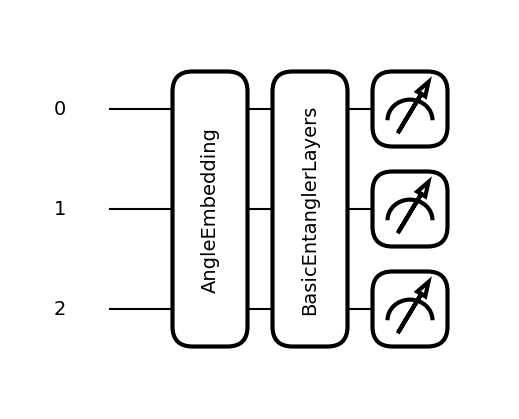

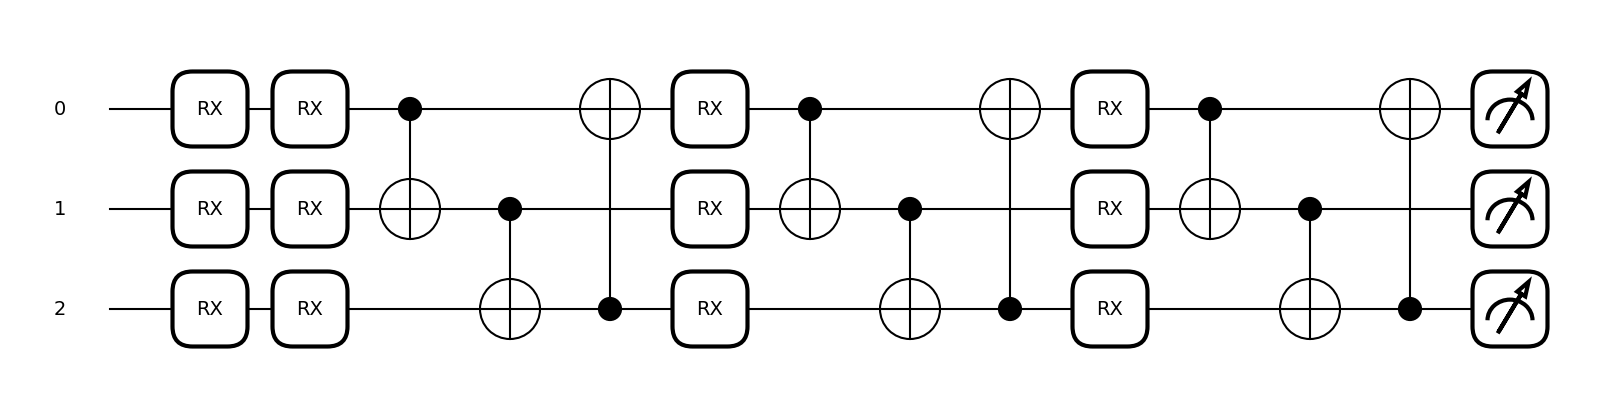

In [6]:
# qml.drawer.use_style("pennylane")
print(qml.draw(circuit, expansion_strategy="device")(inputs, weights))
fig1, ax = qml.draw_mpl(circuit)(inputs, weights)
fig2, ax = qml.draw_mpl(circuit, expansion_strategy="device")(inputs, weights)

In [7]:
import pennylane as qml
import numpy as np

# Define the angles you want to encode
angles = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

# Initialize a quantum device (in this case, a simulator)
dev = qml.device("default.qubit", wires=3)


@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def multiple_angle_embedding_circuit(features):
    # Encode the first 3 features as angles for x rotations
    qml.AngleEmbedding(features[:3], wires=range(3), rotation="X")

    # Encode the next 3 features as angles for z rotations
    qml.AngleEmbedding(features[3:6], wires=range(3), rotation="Z")

    # Encode the last 2 features as angles for y rotations
    qml.AngleEmbedding(features[6:], wires=[0, 1], rotation="Y")

    return qml.state()


# Execute the circuit and get the quantum state
quantum_state = multiple_angle_embedding_circuit(angles)

# Print the quantum state
print(quantum_state)

tensor([ 0.1661-0.4570j, -0.0151-0.1232j,  0.0921-0.5659j, -0.0446-0.1395j,
         0.1057-0.3809j, -0.0201-0.0989j,  0.0388-0.4645j, -0.0450-0.1102j],
       dtype=torch.complex128)


0: ──RX(0.10)──RZ(0.70)──RY(1.30)─┤ ╭State
1: ──RX(0.30)──RZ(0.90)──RY(1.50)─┤ ├State
2: ──RX(0.50)──RZ(1.10)───────────┤ ╰State


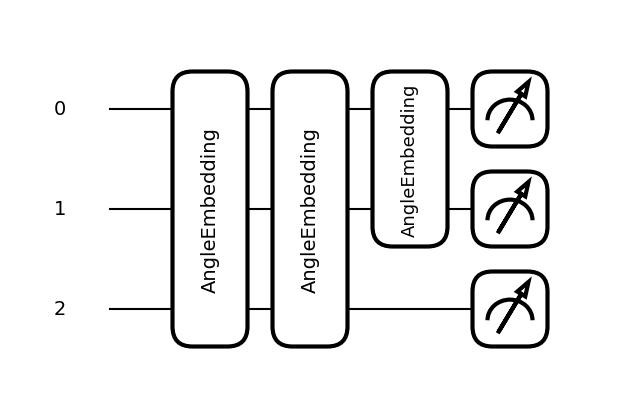

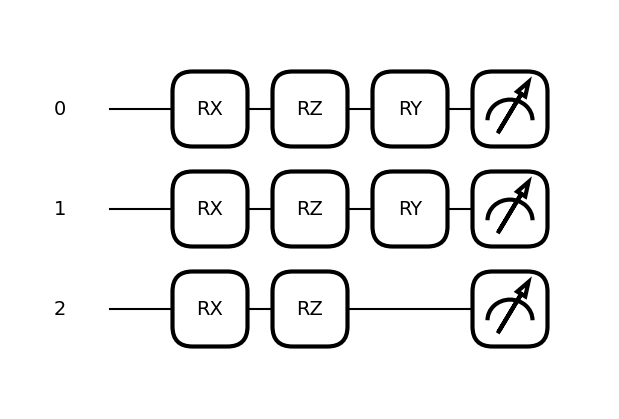

In [9]:
print(qml.draw(multiple_angle_embedding_circuit, expansion_strategy="device")(angles))
fig1, ax = qml.draw_mpl(multiple_angle_embedding_circuit)(angles)
fig2, ax = qml.draw_mpl(multiple_angle_embedding_circuit, expansion_strategy="device")(
    angles
)

In [ ]:
# import torch.nn.functional as F

# # Optionally use the context manager to ensure one of the fused kernels is run
# query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# with torch.backends.cuda.sdp_kernel(enable_math=False):
#     F.scaled_dot_product_attention(query, key, value)